__author__ == pancham_banerjee

In [18]:
import os
import json
import time
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

### What are we predicting?
A loyalty score for each card_id represented in test.csv and sample_submission.csv.

### File descriptions
* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
* historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
* merchants.csv - additional information about all merchants / merchant_ids in the dataset.
* new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

In [3]:
df_train = pd.read_csv('train.csv', parse_dates = ['first_active_month'])
df_test = pd.read_csv('test.csv', parse_dates = ['first_active_month'])

print(df_train.shape, df_test.shape)

(201917, 6) (123623, 5)


In [4]:
df_train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913


In [5]:
df_test.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0


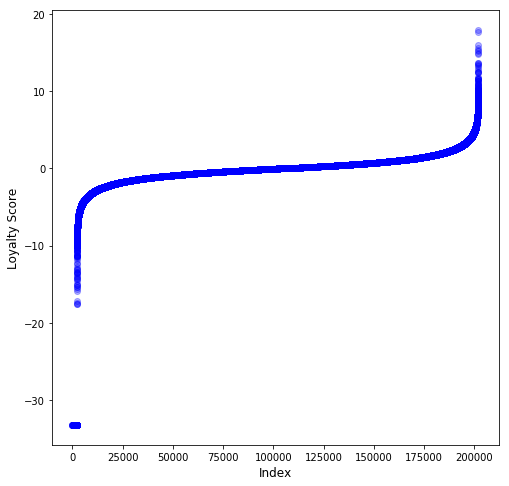

In [6]:
target_col = "target"

plt.figure(figsize=(8,8))
plt.scatter(range(df_train.shape[0]), np.sort(df_train[target_col].values),color='b',alpha=.3)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

According to https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo, since our prediction metric is RMSE, we need to be mindful of the cluster of outliers with a target value < -30. We can try and take this into account later. 

In [7]:
len(df_train[df_train['target']<-30]) # 2207 such ids in the training set

2207

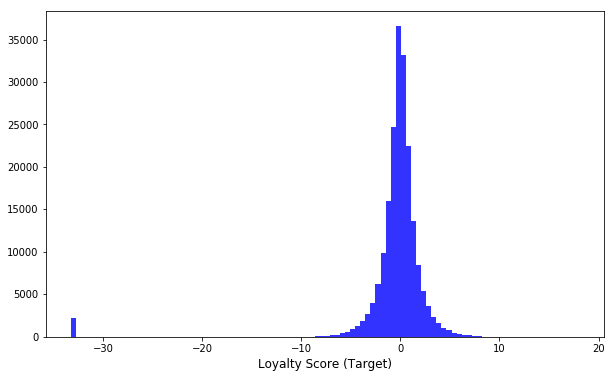

In [8]:
plt.figure(figsize=(10,6))
plt.hist(df_train.target, bins=100, color='b', alpha=.8)
plt.xlabel('Loyalty Score (Target)', fontsize=12);

The histogram of the loyalty score is pretty Gaussian, aside from the 2207 outliers with a loyalty score < -30

We want to check if feature_1, feature_2 and feature_2 are categorical

In [9]:
df_train['feature_1'].value_counts()

3    73573
2    55797
5    40625
4    19885
1    12037
Name: feature_1, dtype: int64

In [10]:
df_train['feature_2'].value_counts()

1    89242
2    74839
3    37836
Name: feature_2, dtype: int64

In [11]:
df_train['feature_3'].value_counts()

1    114198
0     87719
Name: feature_3, dtype: int64

They definitely seem to be categorical features so we can use one-hot encoding

In [12]:
df_train.isna().sum() # No missing vals in the train set

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [13]:
df_train['year'] = df_train['first_active_month'].dt.year
df_train['month'] = df_train['first_active_month'].dt.month

In [14]:
feature1_dummies = pd.get_dummies(df_train['feature_1'],prefix='feature1')
df_train = pd.concat([df_train,feature1_dummies],axis=1)

feature2_dummies = pd.get_dummies(df_train['feature_2'],prefix='feature2')
df_train = pd.concat([df_train,feature2_dummies],axis=1)

feature3_dummies = pd.get_dummies(df_train['feature_3'],prefix='feature3')
df_train = pd.concat([df_train,feature3_dummies], axis=1)

df_train.drop(['feature_1','feature_2','feature_3'], axis=1, inplace=True) # First effort drop the original
# categorical columns after  one-hot encoding

df_train.head(2)

,first_active_month,card_id,target,year,month,feature1_1,feature1_2,feature1_3,feature1_4,feature1_5,feature2_1,feature2_2,feature2_3,feature3_0,feature3_1
0,2017-06-01,C_ID_92a2005557,-0.820283,2017,6,0,0,0,0,1,0,1,0,0,1
1,2017-01-01,C_ID_3d0044924f,0.392913,2017,1,0,0,0,1,0,1,0,0,1,0


What kind of accuracy are we getting on the train set without including any additional files?

In [15]:
X = df_train.drop(['card_id','first_active_month','target'], axis=1)
y = df_train.target

Let's also run the same feature engineering on the test data (will be converted to a convenience function later)

In [38]:
df_test['year'] = df_test['first_active_month'].dt.year
df_test['month'] = df_test['first_active_month'].dt.month

feature1_dummies = pd.get_dummies(df_test['feature_1'],prefix='feature1')
df_test = pd.concat([df_test,feature1_dummies],axis=1)

feature2_dummies = pd.get_dummies(df_test['feature_2'],prefix='feature2')
df_test = pd.concat([df_test,feature2_dummies],axis=1)

feature3_dummies = pd.get_dummies(df_test['feature_3'],prefix='feature3')
df_test = pd.concat([df_test,feature3_dummies], axis=1)

df_test.drop(['feature_1','feature_2','feature_3'], axis=1, inplace=True)

### 1. Random Forests



In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(max_depth=2,n_estimators=200, random_state=42)
start = time.time()
rf.fit(X_train,y_train)
print("Time elapsed:: {} s".format(time.time() - start))
pred = rf.predict(X_test)
print("RMSE: {}".format(np.sqrt(mean_squared_error(pred,y_test))))

Time elapsed:: 6.500522136688232 s
RMSE: 3.8677202183059824


An error of 3.8677 isn't great, so let's try to GridSearch the hyperparameters for our model

In [23]:
# param_grid = {'max_depth': [2, 5, 10],
#               'n_estimators': [100, 500],
#              'min_samples_split': [2, 5, 10]}

# rf = RandomForestRegressor(random_state=42)
# start = time.time()
# gridsearch_rf = GridSearchCV(rf, param_grid, cv = 3, return_train_score=True) # 3-fold cross-validation
# gridsearch_rf.fit(X_train,y_train)
# print("Time elapsed:: {} s".format(time.time() - start))
# pred = gridsearch_rf.predict(X_test)
# print("RMSE: {}".format(np.sqrt(mean_squared_error(pred,y_test))))

Time elapsed:: 727.6988253593445 s
RMSE: 3.8670213620774088


A lot of computation time for marginal gains. (Commenting out the above for later runs) Let us use the best params from above to try and replicate the results. 

In [25]:
# print("Best parameters: {}".format(gridsearch_rf.best_params_))

Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [26]:
rf = RandomForestRegressor(max_depth=5, min_samples_split=2, n_estimators=100, random_state=42)
start = time.time()
rf.fit(X_train,y_train)
print("Time elapsed:: {} s".format(time.time() - start))
pred = rf.predict(X_test)
print("RMSE: {}".format(np.sqrt(mean_squared_error(pred,y_test))))

Time elapsed:: 6.278579235076904 s
RMSE: 3.8670213620774088


Let's try one fit for a slightly different set of hyperparameters. In general, GridSearchCV isn't very feasible, but we could try and implement Random Grid Search (https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74). 

In [30]:
rf = RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=500, random_state=42, warm_start=True)
start = time.time()
rf.fit(X_train,y_train)
print("Time elapsed:: {} s".format(time.time() - start))
pred = rf.predict(X_test)
print("RMSE: {}".format(np.sqrt(mean_squared_error(pred,y_test))))

Time elapsed:: 31.37404704093933 s
RMSE: 3.867026638220713


The above gives a slightly worse performance than our best RMSE above. 
### Are we overfitting? 

In [34]:
r2_score(y_true=y_test,y_pred=pred) 

0.0046652659529715645

Am I missing something? Or do the predicted target and the actual y_test not correlate at all?

### 2. LightGBM -- params from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo. hyperparameters have to be investigated. 

In [40]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, \
                      verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    
    return pred_test_y, model, evals_result

In [41]:
train_X = df_train.drop(['card_id','first_active_month','target'], axis=1)
test_X = df_test.drop(['card_id','first_active_month'], axis=1)
train_y = df_train['target'].values

In [43]:
# 5-fold Cross-validation, averaging the results
pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)
for dev_index, val_index in kf.split(df_train):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.86777
Early stopping, best iteration is:
[59]	valid_0's rmse: 3.8675
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.85629
Early stopping, best iteration is:
[60]	valid_0's rmse: 3.85594
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.97305
Early stopping, best iteration is:
[96]	valid_0's rmse: 3.97301
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.72951
Early stopping, best iteration is:
[54]	valid_0's rmse: 3.72868
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.78017
Early stopping, best iteration is:
[42]	valid_0's rmse: 3.77871


That isn't a bad RMSE, given our RF results. Let's also look at the feature importances. 

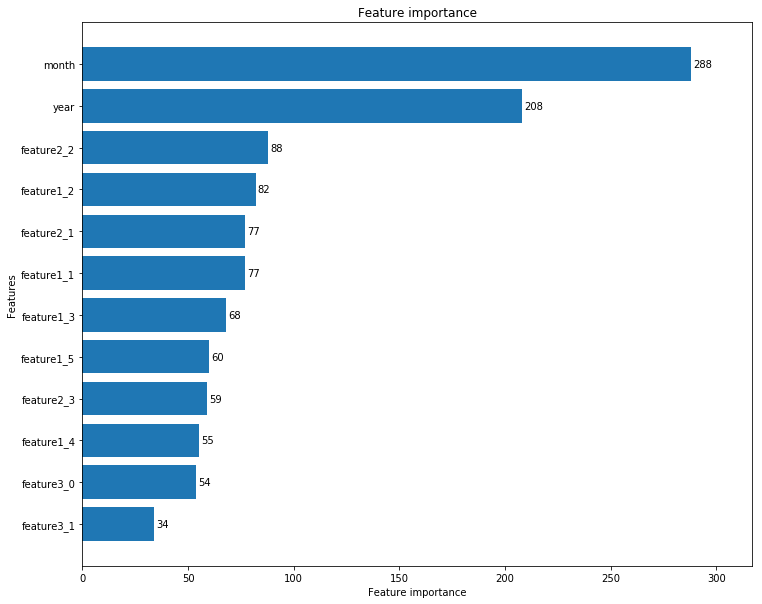

In [46]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False);

So month and date are very important, and feature_1 seems to be more important than feature_2 and feature_3. What are the possible interpretations of these features?

### Let's now try to include the other datasets

In [47]:
df_hist = pd.read_csv('historical_transactions.csv')
df_hist.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16


In [49]:
df_hist.shape

(29112361, 14)

In [50]:
df_hist.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

* card_id - Card identifier
* month_lag - month lag to reference date
* purchase_date - Purchase date
* authorized_flag - 'Y' if approved, 'N' if denied
* category_3 - anonymized category
* installments - number of installments of purchase
* category_1 - anonymized category
* merchant_category_id - Merchant category identifier (anonymized )
* subsector_id - Merchant category group identifier (anonymized )
* merchant_id - Merchant identifier (anonymized)
* purchase_amount - Normalized purchase amount
* city_id - City identifier (anonymized )
* state_id - State identifier (anonymized )
* category_2 - anonymized category

It makes sense that the number of historical transactions would affect the loyalty

In [56]:
df1 = df_hist.groupby('card_id')
df1 = df1['purchase_amount'].size().reset_index()
df1.columns = ['card_id', 'num_hist']
df_train = pd.merge(df_train,df1,on='card_id',how='left')
df_test = pd.merge(df_test,df1,on='card_id',how='left')

Similarly, the total purchase amount should be a factor

In [57]:
df2 = df_hist.groupby('card_id')['purchase_amount'].agg(['sum']).reset_index()
df2.columns = ['card_id','sum_purchase']
df_train = pd.merge(df_train,df2,on='card_id',how='left')
df_test = pd.merge(df_test,df2,on='card_id',how='left')

For now, let's just extract these 2 features from df_hist. We can encode the other categorical/numerical variables later. 

In [58]:
df_new = pd.read_csv('new_merchant_transactions.csv') # This dataset should be completely unique to the historical one
df_new.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19


In [59]:
df_new.shape # Same columns as df_hist

(1963031, 14)

Similar to the historical transactions, let us build the 'total transactions' and 'total purchase cost' from this dataset. 

In [60]:
df1 = df_new.groupby('card_id')['purchase_amount'].size().reset_index()
df1.columns = ['card_id', 'num_hist']
df_train = pd.merge(df_train,df1,on='card_id',how='left')
df_test = pd.merge(df_test,df1,on='card_id',how='left')

In [61]:
df2 = df_new.groupby('card_id')['purchase_amount'].agg(['sum']).reset_index()
df2.columns = ['card_id','sum_purchase'] # Should give the column a different name
df_train = pd.merge(df_train,df2,on='card_id',how='left')
df_test = pd.merge(df_test,df2,on='card_id',how='left')

In [62]:
print(df_train.shape, df_test.shape)

(201917, 19) (123623, 18)


In [64]:
df_train.head(2)

,first_active_month,card_id,target,year,month,feature1_1,feature1_2,feature1_3,feature1_4,feature1_5,feature2_1,feature2_2,feature2_3,feature3_0,feature3_1,num_hist_x,sum_purchase_x,num_hist_y,sum_purchase_y
0,2017-06-01,C_ID_92a2005557,-0.820283,2017,6,0,0,0,0,1,0,1,0,0,1,260,-165.968739,23.0,-13.244202
1,2017-01-01,C_ID_3d0044924f,0.392913,2017,1,0,0,0,1,0,1,0,0,1,0,350,-210.006336,6.0,-4.355735


In [67]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 19 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
target                201917 non-null float64
year                  201917 non-null int64
month                 201917 non-null int64
feature1_1            201917 non-null uint8
feature1_2            201917 non-null uint8
feature1_3            201917 non-null uint8
feature1_4            201917 non-null uint8
feature1_5            201917 non-null uint8
feature2_1            201917 non-null uint8
feature2_2            201917 non-null uint8
feature2_3            201917 non-null uint8
feature3_0            201917 non-null uint8
feature3_1            201917 non-null uint8
num_hist_x            201917 non-null int64
sum_purchase_x        201917 non-null float64
num_hist_y            179986 non-null float64
sum_purchase_y        179986 non-null float64
dtypes: datetime64[ns](1), float64(

Will the fact that not all similar columns are the same datatype make a difference? Check later
### Apply LightGBM again to the slightly expanded train and test sets

In [68]:
train_X = df_train.drop(['card_id','first_active_month','target'], axis=1)
test_X = df_test.drop(['card_id','first_active_month'], axis=1)
train_y = df_train['target'].values

In [69]:
# 5-fold Cross-validation, averaging the results
pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)
for dev_index, val_index in kf.split(df_train):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.83626
[200]	valid_0's rmse: 3.83521
[300]	valid_0's rmse: 3.83628
Early stopping, best iteration is:
[200]	valid_0's rmse: 3.83521
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.82236
[200]	valid_0's rmse: 3.82025
Early stopping, best iteration is:
[183]	valid_0's rmse: 3.82001
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.94485
[200]	valid_0's rmse: 3.94379
Early stopping, best iteration is:
[196]	valid_0's rmse: 3.94367
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.70091
[200]	valid_0's rmse: 3.70068
Early stopping, best iteration is:
[163]	valid_0's rmse: 3.7004
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.7484
[200]	valid_0's rmse: 3.74755
Early stopping, best iteration is:
[197]	valid_0's rmse: 3.74751


So we get a better RMSE value than before. Let's take a look at the feature importances. 

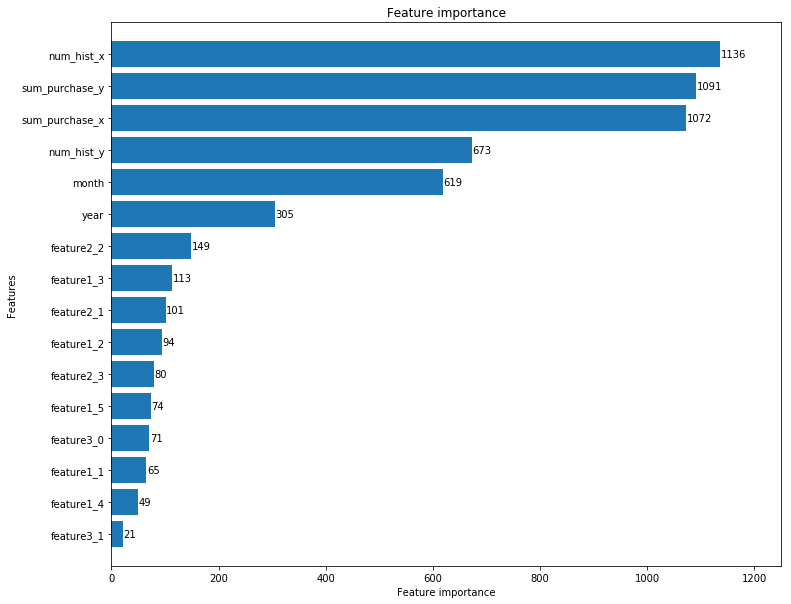

In [70]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False);

### So we see that the features generated from the 2 additional datasets greatly affect the target prediction. Let's create our first submission. 

In [71]:
df_submission = pd.DataFrame({"card_id":df_test["card_id"].values})
df_submission["target"] = pred_test
df_submission.to_csv("mds_einstein_sub1.csv", index=False)

### A leaderboard score of 3.886, which isn't very good, and probably implies that we are overfitting. So we should look to reducing the number of features, and hyperparameter tuning.  

### Future plans:: 
* Reduce overfitting by reducing number of features
* Implement other aggregations (mean, std, min, max etc) on the purchases from the two subsidiary datasets
* Parameter tuning for LightGBM
* Look at other features from the df_hist and df_new dataframes
* We haven't used the merchants.csv file at all yet